In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, laplace, uniform

# Stochastic Volatility Model

Transition model:
$$ X_k = aX_{k-1} + bW_k$$
Observation model:
$$ Y_k =ce^{X_k/2}V_k$$
where $X_{-1} = 0$, $W_k \sim N(0,1)$ and $Y_k \sim N(0,1)$

In [2]:
def generateVolatility(a, b, c,length):
    x = np.zeros(length)
    y = np.zeros(length)
    
    current_x = 3
    for ind in range(length):
        w,v = np.random.randn(), np.random.randn()
        current_x = a * current_x + b * w
        x[ind] = current_x
        y[ind] = c * np.exp(current_x / 2.) * v
        
    return x, y

In [10]:
def particleFilter(a, b, c, y, num_samples, trial_dist):
    particles = np.zeros((num_samples,2))
    particles[:,0] = trial_dist.rvs(size = num_samples)
    weights = norm.pdf(particles[:,0], 0, b) * norm.pdf(y[0], 0, np.exp(particles[:,0] / 2.0) * c) / trial_dist.pdf(particles[:,0],0, b)
    #print(weights)
    particles[:,1] = weights
    res = np.zeros(len(y))
    
    for ind in range(len(y) - 1):
        res[ind] = np.dot(particles[:,0], particles[:,1]) / np.sum(particles[:,1])
        chosen = np.random.choice(list(range(num_samples)), size = num_samples, p = particles[:,1] / np.sum(particles[:,1]))
        
        # Resampling
        particles[:,0] = np.take(particles[:,0], chosen, axis = 0)
        particles[:,1] = np.ones(num_samples) * np.sum(particles[:,1]) / num_samples
        
        # Propagation
        new_particles = particles[:,0] * a + b * trial_dist.rvs(size = num_samples)
        particles[:,1] *= norm.pdf(new_particles, a * particles[:,0], b) * norm.pdf(y[ind + 1], 0, c * np.exp(particles[:,0] / 2.)) / trial_dist.pdf(new_particles, a * particles[:,0], b)
        particles[:,0] = new_particles
        particles[:,1] = particles[:,1]/np.sum(particles[:,1])
    
    return res
    
    

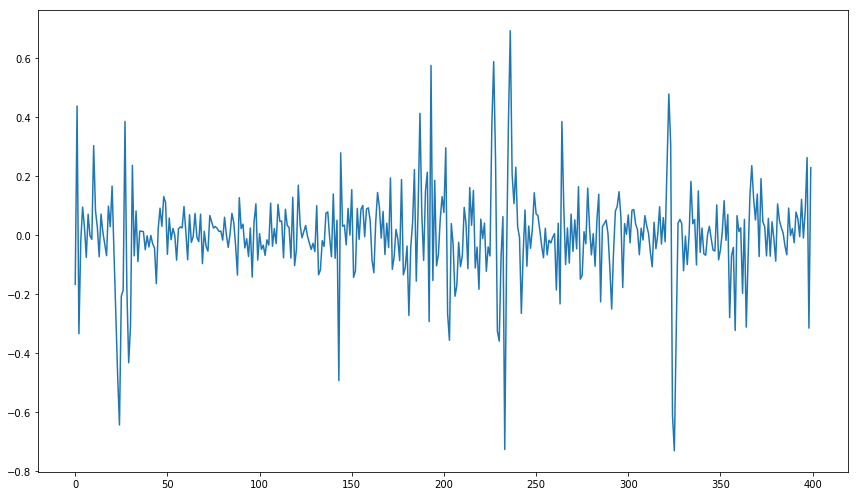

In [56]:
a, b, c = 0.9, 0.5, 0.1
x, y = generateVolatility(a,b,c, 400)
particles = particleFilter(a, b, c, y, 1000,  norm)
particles_laplace = particleFilter(a,b,c,y, 3000, laplace)
fig = plt.gcf()
fig.set_size_inches(14.5, 8.5)
plt.plot(y)
plt.show()

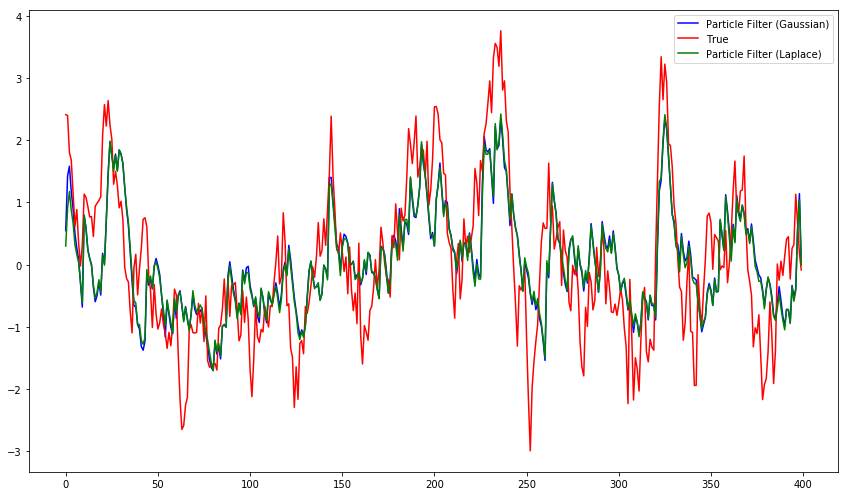

In [57]:
fig = plt.gcf()
fig.set_size_inches(14.5, 8.5)
plt.plot(particles, 'b', label = 'Particle Filter (Gaussian)')
plt.plot(x, 'r', label = 'True')
plt.plot(particles_laplace, 'g', label = 'Particle Filter (Laplace)')
plt.legend()
plt.show()

# State space model with Gaussian noise

Transition model:
$$ X_{k+1} = aX_{k} + bW_{k+1}$$
Observation model:
$$ Y_{k+1} = cX_{k+1} + dV_{k+1}$$

where $X_{-1} = constant$, $W_k \sim N(0,1)$ and $V_k \sim N(0,1)$

In [129]:
def generateGaussianStateSpace(a,b,c,d, initial_mean, length):
    x = np.zeros(length)
    y = np.zeros(length)
    
    current_x = initial_mean
    for ind in range(length):
        current_x = current_x * a + b * np.random.randn()
        x[ind] = current_x
        y[ind] = c * current_x + d * np.random.randn()
        
    return x,y

def kalmanFilter(a,b,c,d,y, initial_mean):
    
    res_mean = np.zeros(len(y))
    res_var = np.zeros(len(y))
    mean, var = initial_mean, b**2
    
    for ind in range(len(y)):
        
        # Update step
        updated_mean = mean + c * var / (c**2 * var + d**2) * (y[ind] - c * mean)
        updated_var = var - c**2 * var**2 / (c**2*var + d**2)
        res_mean[ind], res_var[ind] = updated_mean, updated_var

        # Prediction step
        mean = a * updated_mean
        var = a**2 * updated_var + b**2
    
    return res_mean, res_var
    

In [264]:
def particleFilterGaussianStateSpace(a, b, c, d, y, num_samples):
    particles = np.random.randn(num_samples,2) *b

    weights = norm.pdf((y[0] - particles[:,0] * c)/d)
    particles[:,1] = weights
    res = np.zeros(len(y))
    
    for ind in range(len(y) - 1):
        res[ind] = np.dot(particles[:,0], particles[:,1]) / np.sum(particles[:,1])
        
        # Resampling
        chosen = np.random.choice(list(range(num_samples)), size = num_samples, p = particles[:,1] / np.sum(particles[:,1]))
        particles[:,0] = np.take(particles[:,0], chosen, axis = 0)
        particles[:,1] = np.ones(num_samples) * np.sum(particles[:,1]) / num_samples
        
        # Propagation
        particles[:,0] = particles[:,0] * a + b * np.random.randn(num_samples)
        increment = norm.pdf((y[ind + 1] - particles[:,0] * c) / d)
        particles[:,1] *= increment
        particles[:,1] = particles[:,1] / np.sum(particles[:,1])

    return res
    

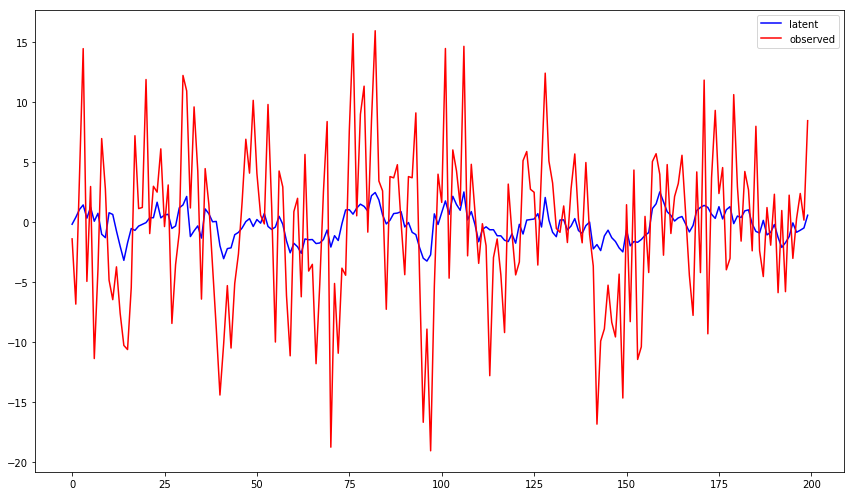

In [265]:
a,b,c,d = 0.7,0.9,3,5
initial_mean = 0
x,y = generateGaussianStateSpace(a,b,c,d, initial_mean, 200)
res_mean, res_var = kalmanFilter(a,b,c,d,y, initial_mean)
res = particleFilterGaussianStateSpace(a,b,c,d,y, 100)

fig = plt.gcf()
fig.set_size_inches(14.5, 8.5)
plt.plot(x,'b',label = 'latent')
plt.plot(y,'r', label = 'observed')
plt.legend()
plt.show()

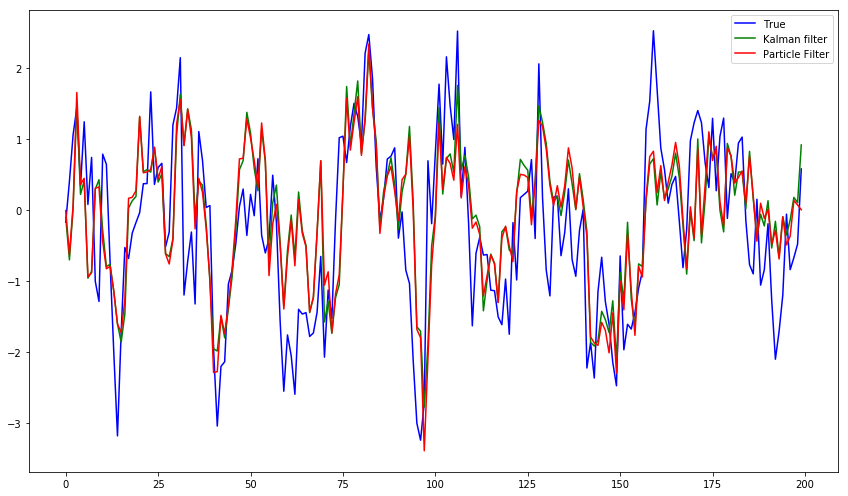

In [266]:
fig = plt.gcf()
fig.set_size_inches(14.5, 8.5)
plt.plot(x,'b', label = 'True')
plt.plot(res_mean, 'g', label = 'Kalman filter')
plt.plot(res, 'r', label = 'Particle Filter')
plt.legend()
plt.show()

array([0.43989355, 0.42141179, 0.40548829, 0.33301012, 0.39157359,
       0.42160428, 0.41006923, 0.67260281, 0.59835467, 0.60537017,
       0.80071491, 0.78056932, 0.73147266, 0.69477127, 0.69101165,
       0.66618001, 0.5872561 , 0.5500206 , 0.63307082, 0.75465245,
       0.75659002, 0.7763329 , 0.64706729, 0.61985382, 0.63359183,
       0.64510936, 0.60888016, 0.67370261, 0.9143539 , 0.85364658,
       0.90086723, 0.98279812, 0.92395707, 0.93217166, 0.86875098,
       0.78095274, 0.904517  , 1.21519323, 1.09493613, 0.95008637,
       0.99838724, 0.92290906, 0.94206164, 0.8779358 , 1.0420092 ,
       1.00011049, 0.91828415, 0.9021514 , 0.88474067, 0.80143732,
       0.92288998, 0.89202118, 0.80548726, 0.73851347, 0.70747826,
       0.65433973, 0.9991156 , 0.9242006 , 1.14999197, 1.2932509 ,
       1.28466929, 1.3612628 , 1.22702986, 1.13482474, 1.19123649,
       1.49267827, 1.35402071, 1.25922124, 1.16200291, 1.56407375,
       1.37211069, 1.34284545, 1.28844147, 1.22274766, 1.10763